In [13]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

import pandas as pd
import umap
# （以下、もともとのコードが続く…）


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import openpyxl

# 1. データ読み込み
xls = pd.ExcelFile("../../data/定額制動画配信.xlsx")
df = pd.read_excel(xls, sheet_name="data")
format_df = pd.read_excel(xls, sheet_name="Format")

# 2. サービスコード→サービス名マッピング（SQ6_1ベース）
sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}


# 3. 特徴量集計関数
def make_feature_df(df):
    features = []
    for code, svc in code_title.items():
        sub = df[df["SQ6_2"] == code]  # SQ6_2 = 「最もよく使っているサービス」
        if sub.empty:
            continue
        feat = {"Service": svc,
                # ① UX体験品質
                "UX_mean": sub[[f"Q2_{i}" for i in range(1,9)]].mean(axis=1).mean(),
                "UI_design": sub["Q2_3"].mean(),
                "Player_usability": sub["Q2_6"].mean(),
                # ② コンテンツ量・新作性
                "Catalogue_volume": sub["Q2_9"].mean(),
                "Genre_coverage_within_category": sub["Q2_10"].mean(),
                "New_release_speed": sub["Q2_11"].mean(),
                "Genre_coverage_among_category": sub[[f"SQ9_1[{i}]" for i in range(1,16)]].sum(axis=1).mean(),
                # ③ 価格バリュー
                "Cost_perf": sub["Q2_14"].mean(),
                # ④ ロイヤルティ
                "Overall_satisfaction": sub["Q1"].mean(),
                "NPS_intention": sub["Q4"].mean(),
                "Continue_intention": sub["Q8"].mean()
               }
        # ⑤ ジャンル強み
        for i in range(1, 16):
            feat[f"Genre_{i}_top_share"] = (sub["SQ9_3"] == i).mean()
        # ⑥ オリジナルコンテンツ力
        feat["Original_viewer_share"] = (sub["Q12M[3]"] == 3).mean()
        feat["Original_quality"] = sub[[f"Q13_{i}" for i in range(1,4)]].mean(axis=1).mean()
        # ⑦ 利用歴／アカウント形態
        tenure_map = {1:1,2:4,3:8,4:18,5:30,6:42}
        feat["Usage_tenure_months"] = sub["SQ8"].map(tenure_map).mean()
        feat["Personal_pay_ratio"] = sub["SQ7"].isin([1,2]).mean()
        # ⑧ 追加サービス／機能
        feat["Extra_service_use"] = sub["SQ10"].isin([1,2]).mean()
        # ⑨ イメージ・信頼
        feat["Corporate_trust"] = sub[["Q2_15","Q2_16"]].mean(axis=1).mean()
        # ⑩ SDGsプレミアム
        feat["SDGs_influence"] = sub["Q22"].mean()
        features.append(feat)
    return pd.DataFrame(features).set_index("Service")


# 4. 特徴量行列作成
feat_df = make_feature_df(df)

#欠損値を平均補完（Original_qualityのみ）
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
feat_df["Original_quality"] = imputer.fit_transform(feat_df[["Original_quality"]])

# 5. スケーリング＆PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feat_df)
feat_df.to_pickle("feat_df.pkl")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [16]:
# ====== 1. 準備 ======
# feat_df: pandas DataFrame with index=Service, columns=features
# Assume feat_df is already defined in the environment
X = torch.tensor(feat_df.values, dtype=torch.float)

# ====== 2. データセット & 増強 ======
class ServiceDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return self.augment(x), self.augment(x)

    def augment(self, x):
        # ランダムガウスノイズによる簡易Augmentation
        noise = torch.randn_like(x) * 0.05
        return x + noise

dataset = ServiceDataset(X)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [17]:
# ====== 3. モデル定義 ======
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, proj_dim=64):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU()
        )
        self.projector = nn.Sequential(
            nn.Linear(proj_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z

class Predictor(nn.Module):
    def __init__(self, proj_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(proj_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)

In [18]:
# ====== 4. BYOLクラス ======
class BYOL(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, proj_dim=64, momentum=0.996):
        super().__init__()
        # online network
        self.online = MLPEncoder(input_dim, hidden_dim, proj_dim)
        self.predictor = Predictor(proj_dim)
        # target network: コピーしてfreeze
        self.target = MLPEncoder(input_dim, hidden_dim, proj_dim)
        for param in self.target.parameters():
            param.requires_grad = False
        self.momentum = momentum

    @torch.no_grad()
    def _momentum_update(self):
        # momentum update: target = m * target + (1-m) * online
        for o_param, t_param in zip(self.online.parameters(), self.target.parameters()):
            t_param.data = t_param.data * self.momentum + o_param.data * (1. - self.momentum)
        for o_param, t_param in zip(self.online.projector.parameters(), self.target.projector.parameters()):
            t_param.data = t_param.data * self.momentum + o_param.data * (1. - self.momentum)

    def forward(self, x1, x2):
        # online forward
        h1_o, z1_o = self.online(x1)
        h2_o, z2_o = self.online(x2)
        p1 = self.predictor(z1_o)
        p2 = self.predictor(z2_o)
        # target forward (no grad)
        with torch.no_grad():
            _, z1_t = self.target(x1)
            _, z2_t = self.target(x2)
        return p1, p2, z1_t.detach(), z2_t.detach()

In [19]:
# ====== 5. 損失関数 ======
def byol_loss(p, z):
    # 正規化
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2 * (p * z).sum(dim=1).mean()

In [20]:
# ====== 6. トレーニング ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BYOL(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(list(model.online.parameters()) + 
                             list(model.predictor.parameters()), lr=1e-3)

n_epochs = 100
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x1, x2 in loader:
        x1, x2 = x1.to(device), x2.to(device)
        p1, p2, z1_t, z2_t = model(x1, x2)
        loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model._momentum_update()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(loader):.4f}")

# ====== 7. 埋め込み抽出 ======
model.eval()
with torch.no_grad():
    h, _ = model.online(X.to(device))
    embeddings = h.cpu().numpy()  # shape = (n_services, proj_dim)

# embeddings を PCA/UMAP に再可視化に利用可能
# 保存
import numpy as np
np.save("../../data/shared/embeddings.npy", embeddings)
np.save("../../data/shared/feat_columns.npy", feat_df.columns.values)
np.save("../../data/shared/X_scaled.npy", X_scaled)

emb_new = np.load("../VAE/emb_new.npy") 

Epoch 1/100, Loss: 3.7090
Epoch 2/100, Loss: 2.7623
Epoch 3/100, Loss: 2.0656
Epoch 4/100, Loss: 1.5098
Epoch 5/100, Loss: 1.1998
Epoch 6/100, Loss: 1.0200
Epoch 7/100, Loss: 0.9206
Epoch 8/100, Loss: 0.7436
Epoch 9/100, Loss: 0.6791
Epoch 10/100, Loss: 0.6194
Epoch 11/100, Loss: 0.6073
Epoch 12/100, Loss: 0.5319
Epoch 13/100, Loss: 0.5174
Epoch 14/100, Loss: 0.5126
Epoch 15/100, Loss: 0.4396
Epoch 16/100, Loss: 0.4400
Epoch 17/100, Loss: 0.4157
Epoch 18/100, Loss: 0.3847
Epoch 19/100, Loss: 0.3578
Epoch 20/100, Loss: 0.3485
Epoch 21/100, Loss: 0.3350
Epoch 22/100, Loss: 0.3214
Epoch 23/100, Loss: 0.3100
Epoch 24/100, Loss: 0.2973
Epoch 25/100, Loss: 0.2798
Epoch 26/100, Loss: 0.2581
Epoch 27/100, Loss: 0.2684
Epoch 28/100, Loss: 0.2439
Epoch 29/100, Loss: 0.2351
Epoch 30/100, Loss: 0.2330
Epoch 31/100, Loss: 0.2078
Epoch 32/100, Loss: 0.2469
Epoch 33/100, Loss: 0.1774
Epoch 34/100, Loss: 0.1853
Epoch 35/100, Loss: 0.1644
Epoch 36/100, Loss: 0.1695
Epoch 37/100, Loss: 0.1618
Epoch 38/1

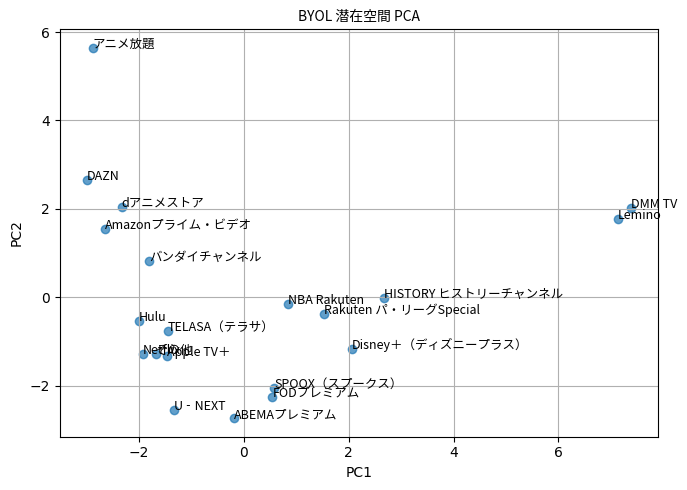

/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


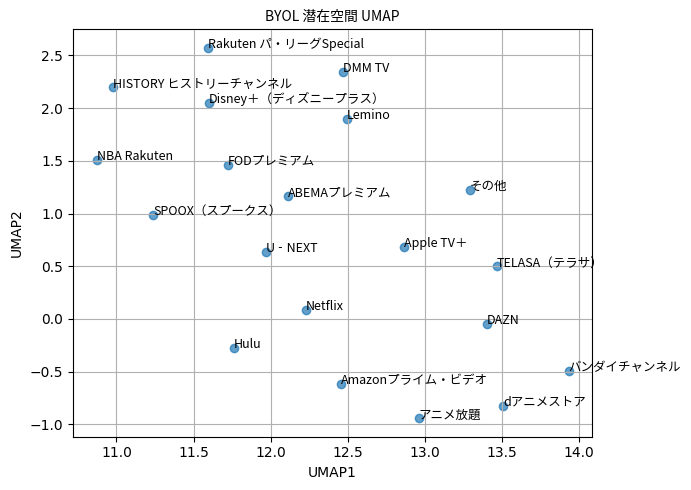

In [21]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# フォント設定
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# 埋め込み読み込み
embeddings = np.load("../../data/shared/embeddings.npy")
feat_df     = pd.read_pickle("../../data/shared/feat_df.pkl")
emb_df      = pd.DataFrame(embeddings, index=feat_df.index)

# PCA
pca = PCA(n_components=2, svd_solver="full", random_state=42)
coords_pca = pca.fit_transform(emb_df)
plt.figure(figsize=(7,5))
plt.scatter(coords_pca[:,0], coords_pca[:,1], alpha=0.7)
for svc, (x, y) in zip(emb_df.index, coords_pca):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=9)
plt.title("BYOL 潜在空間 PCA", fontproperties=font_prop)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.tight_layout()
plt.show()

# UMAP
um = UMAP(n_components=2, random_state=42)
coords_umap = um.fit_transform(emb_df)
plt.figure(figsize=(7,5))
plt.scatter(coords_umap[:,0], coords_umap[:,1], alpha=0.7)
for svc, (x, y) in zip(emb_df.index, coords_umap):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=9)
plt.title("BYOL 潜在空間 UMAP", fontproperties=font_prop)
plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.grid(True); plt.tight_layout()
plt.show()


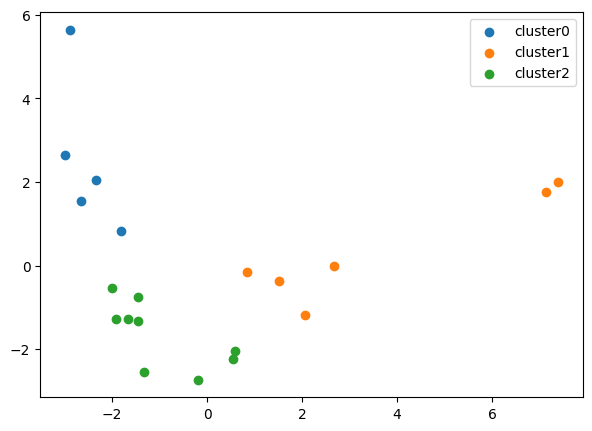

In [22]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters=3, random_state=42).fit_predict(embeddings)
emb_df["cluster"] = labels
# 可視化に色をつけて、各クラスタの特徴（大手／専門／ニッチ）を言語化

# 可視化に色を着ける
plt.figure(figsize=(7,5))
for c in range(3):
    pts = coords_pca[labels==c]
    plt.scatter(pts[:,0], pts[:,1], label=f"cluster{c}")
plt.legend(); plt.show()


In [23]:
import pandas as pd
cluster_feats = feat_df.copy()
cluster_feats["cluster"] = labels
summary = cluster_feats.groupby("cluster").mean().round(2)

# 省略せずに全列・全行を表示する設定
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(summary)

,UX_mean,UI_design,Player_usability,Catalogue_volume,Genre_coverage_within_category,New_release_speed,Genre_coverage_among_category,Cost_perf,Overall_satisfaction,NPS_intention,Continue_intention,Genre_1_top_share,Genre_2_top_share,Genre_3_top_share,Genre_4_top_share,Genre_5_top_share,Genre_6_top_share,Genre_7_top_share,Genre_8_top_share,Genre_9_top_share,Genre_10_top_share,Genre_11_top_share,Genre_12_top_share,Genre_13_top_share,Genre_14_top_share,Genre_15_top_share,Original_viewer_share,Original_quality,Usage_tenure_months,Personal_pay_ratio,Extra_service_use,Corporate_trust,SDGs_influence
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.64,7.64,7.52,7.93,7.34,7.62,1.77,7.95,8.22,7.38,8.30,0.03,0.04,0.02,0.01,0.01,0.67,0.01,0.00,0.00,0.00,0.20,0.0,0.0,0.00,0.0,0.0,7.55,31.84,1.0,0.21,7.99,5.13
1,7.59,7.53,7.59,7.70,7.57,7.59,2.20,7.67,8.01,7.52,7.77,0.01,0.07,0.05,0.06,0.06,0.19,0.02,0.17,0.01,0.00,0.33,0.0,0.0,0.03,0.0,0.0,7.65,16.47,1.0,0.31,7.68,6.46
2,7.51,7.52,7.34,7.51,7.37,7.24,3.83,7.27,7.84,7.29,7.75,0.12,0.13,0.15,0.13,0.05,0.18,0.07,0.04,0.02,0.01,0.09,0.0,0.0,0.00,0.0,0.0,7.55,25.96,1.0,0.34,7.65,6.09


In [24]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(embeddings)
# 各サービスの平均距離を算出→上位の孤立サービスをリストアップ
iso_score = D.mean(axis=1)
display(pd.Series(iso_score, index=feat_df.index).sort_values(ascending=False).head(10))


Service
DMM TV                8.692782
Lemino                8.616070
アニメ放題                 8.300831
DAZN                  7.271380
バンダイチャンネル             6.309720
Amazonプライム・ビデオ        6.112164
HISTORY ヒストリーチャンネル    5.883463
NBA Rakuten           5.877393
dアニメストア               5.710472
Netflix               5.416162
dtype: float32

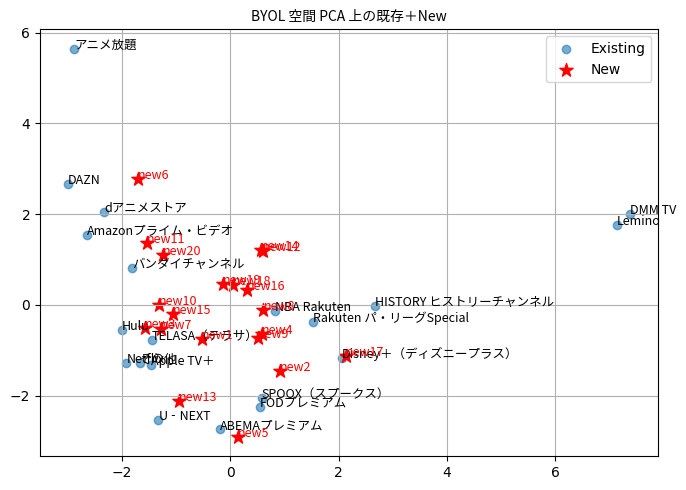

/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


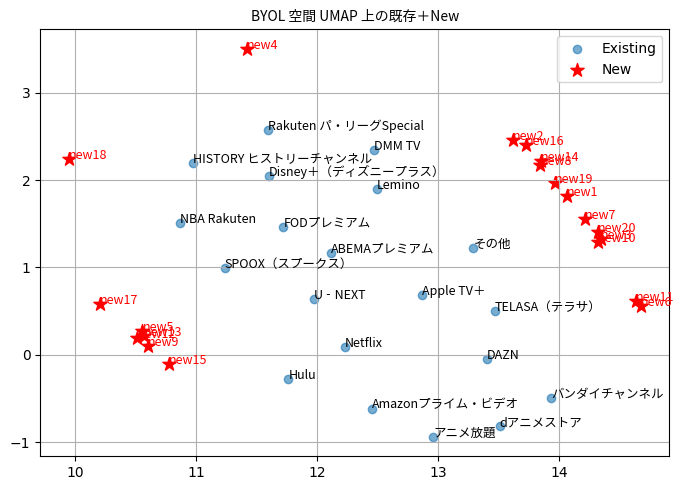

In [25]:
# ====== 8. 可視化 ======
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

emb_df      = pd.DataFrame(embeddings, index=feat_df.index)
emb_new_df  = pd.DataFrame(emb_new)  # index は new サンプルなので不要

# --- PCA ---
pca = PCA(n_components=2, svd_solver="full", random_state=42).fit(emb_df)
coords_exist = pca.transform(emb_df)
coords_new   = pca.transform(emb_new)

plt.figure(figsize=(7,5))
# 既存サービス
plt.scatter(coords_exist[:,0], coords_exist[:,1], alpha=0.6, label="Existing")
for svc, (x,y) in zip(emb_df.index, coords_exist):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=9)
# new サンプル
plt.scatter(coords_new[:,0], coords_new[:,1], marker="*", c="red", s=100, label="New")
for i,(x,y) in enumerate(coords_new,1):
    plt.text(x, y, f"new{i}", fontproperties=font_prop, color="red", fontsize=9)

plt.title("BYOL 空間 PCA 上の既存＋New", fontproperties=font_prop)
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# --- UMAP ---
um = umap.UMAP(n_components=2, random_state=42).fit(emb_df)
coords_exist_umap = um.transform(emb_df)
coords_new_umap   = um.transform(emb_new)

plt.figure(figsize=(7,5))
plt.scatter(coords_exist_umap[:,0], coords_exist_umap[:,1], alpha=0.6, label="Existing")
for svc, (x,y) in zip(emb_df.index, coords_exist_umap):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=9)
plt.scatter(coords_new_umap[:,0], coords_new_umap[:,1], marker="*", c="red", s=100, label="New")
for i,(x,y) in enumerate(coords_new_umap,1):
    plt.text(x, y, f"new{i}", fontproperties=font_prop, color="red", fontsize=9)

plt.title("BYOL 空間 UMAP 上の既存＋New", fontproperties=font_prop)
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


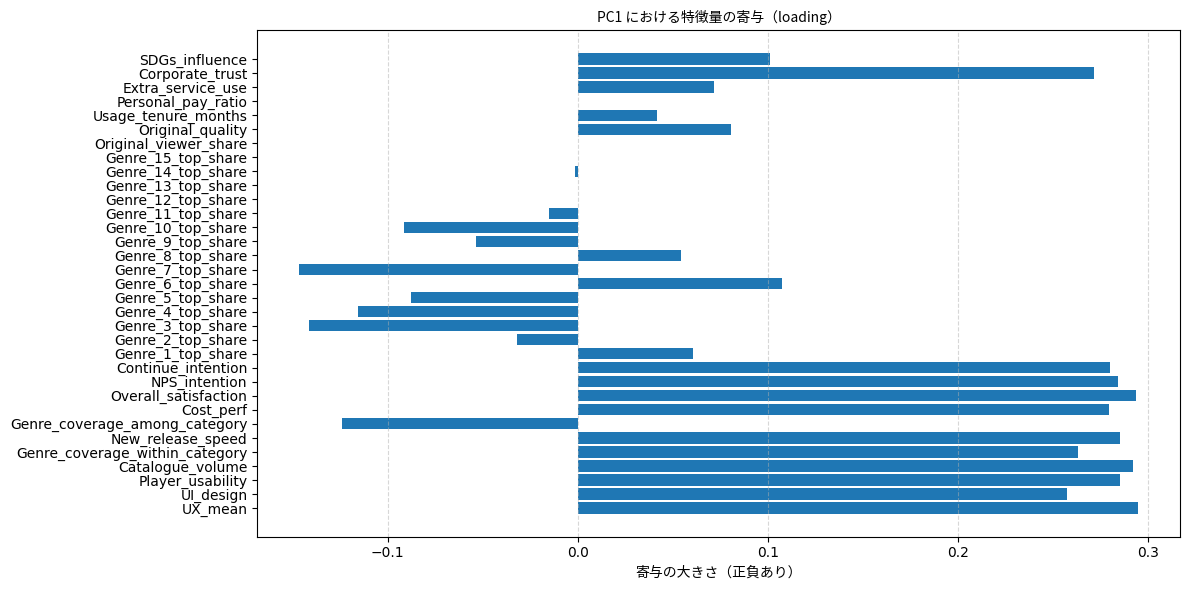

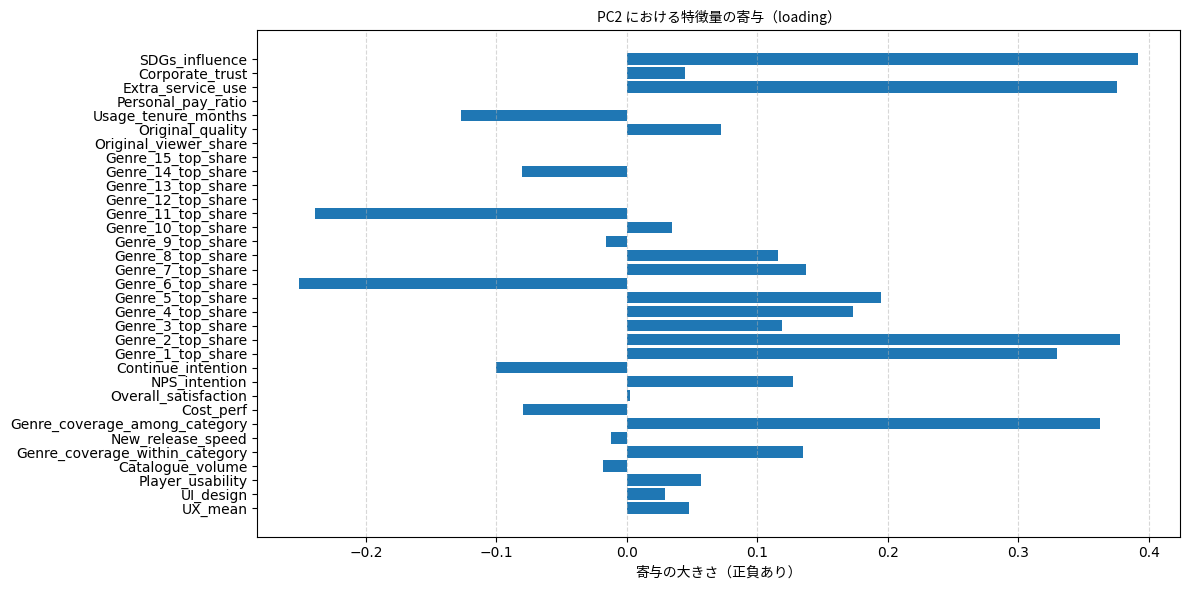

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ── 1. 特徴量行列の読み込み ─────────────────────────────
# feat_df は前段で作成済みの pandas.DataFrame（index=サービス名, columns=33特徴量）
# scaler も同様に定義済みとします

# スケーリング済みデータ（もしメモリ上に X_scaled がなければ再計算）
X_scaled = scaler.transform(feat_df)  # または scaler.fit_transform(feat_df) 

# ── 2. 元特徴量に PCA をあらためて適用 ─────────────────────
pca_feat = PCA(n_components=2, random_state=42)
pca_feat.fit(X_scaled)

# components_ の shape は (2, n_features=33)
loadings = pca_feat.components_

# 特徴量名リスト
feature_names = feat_df.columns.tolist()

# ── 3. PC1 のロードを可視化 ────────────────────────────────
plt.figure(figsize=(12, 6))
plt.barh(feature_names, loadings[0], align='center')
plt.title("PC1 における特徴量の寄与（loading）", fontproperties=font_prop)
plt.xlabel("寄与の大きさ（正負あり）",          fontproperties=font_prop)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ── 4. PC2 のロードを可視化 ────────────────────────────────
plt.figure(figsize=(12, 6))
plt.barh(feature_names, loadings[1], align='center')
plt.title("PC2 における特徴量の寄与（loading）", fontproperties=font_prop)
plt.xlabel("寄与の大きさ（正負あり）",          fontproperties=font_prop)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [28]:
feat_df

,UX_mean,UI_design,Player_usability,Catalogue_volume,Genre_coverage_within_category,New_release_speed,Genre_coverage_among_category,Cost_perf,Overall_satisfaction,NPS_intention,Continue_intention,Genre_1_top_share,Genre_2_top_share,Genre_3_top_share,Genre_4_top_share,Genre_5_top_share,Genre_6_top_share,Genre_7_top_share,Genre_8_top_share,Genre_9_top_share,Genre_10_top_share,Genre_11_top_share,Genre_12_top_share,Genre_13_top_share,Genre_14_top_share,Genre_15_top_share,Original_viewer_share,Original_quality,Usage_tenure_months,Personal_pay_ratio,Extra_service_use,Corporate_trust,SDGs_influence
Service,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apple TV＋,7.450000,8.000000,6.800000,7.000000,6.400000,6.600000,3.800000,6.800000,7.000000,7.000000,7.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,6.500000,27.600000,1.0,0.200000,7.700000,5.600000
アニメ放題,9.000000,9.500000,9.166667,9.666667,9.666667,8.666667,1.000000,9.500000,9.666667,8.666667,9.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,7.581983,34.000000,1.0,0.166667,9.333333,5.666667
ABEMAプレミアム,7.524648,7.591549,7.394366,7.521127,7.507042,7.323944,3.873239,7.352113,8.042254,7.394366,8.070423,0.014085,0.042254,0.098592,0.014085,0.056338,0.295775,0.169014,0.098592,0.042254,0.014085,0.154930,0.0,0.0,0.000000,0.0,0.0,7.777778,22.929577,1.0,0.309859,7.507042,6.366197
Amazonプライム・ビデオ,7.449935,7.488220,7.274869,7.417539,7.442408,7.149215,4.655759,7.710733,8.098168,7.650524,8.178010,0.140052,0.223822,0.078534,0.068063,0.030105,0.379581,0.028796,0.009162,0.013089,0.010471,0.018325,0.0,0.0,0.000000,0.0,0.0,7.616970,33.599476,1.0,0.774869,7.853403,6.079843
FODプレミアム,7.250000,7.075000,7.225000,7.275000,7.300000,7.125000,3.775000,6.875000,7.575000,7.100000,7.500000,0.100000,0.000000,0.475000,0.025000,0.025000,0.150000,0.050000,0.000000,0.025000,0.000000,0.150000,0.0,0.0,0.000000,0.0,0.0,8.200000,22.050000,1.0,0.325000,7.337500,6.075000
SPOOX（スプークス）,8.083333,7.666667,8.000000,8.000000,8.000000,8.333333,3.333333,7.666667,8.666667,8.666667,8.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,7.581983,22.666667,1.0,1.000000,8.333333,8.333333
DAZN,6.691092,6.758621,6.417625,6.808429,6.065134,7.057471,1.072797,5.938697,6.954023,6.130268,7.214559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,7.394608,35.616858,1.0,0.022989,6.262452,5.072797
dアニメストア,7.611301,7.633562,7.554795,8.270548,7.534247,8.041096,1.123288,8.448630,8.356164,7.797945,8.609589,0.000000,0.000000,0.000000,0.000000,0.000000,0.993151,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.006849,0.0,0.0,7.581983,29.958904,1.0,0.099315,8.318493,4.671233
DMM TV,7.291667,7.066667,7.533333,7.844444,7.622222,7.111111,2.555556,7.822222,8.044444,7.244444,7.644444,0.044444,0.022222,0.000000,0.022222,0.000000,0.666667,0.000000,0.000000,0.044444,0.000000,0.000000,0.0,0.0,0.200000,0.0,0.0,7.481481,8.844444,1.0,0.266667,7.655556,5.511111
